# AQI Calculation and Prediction

### Now that our dataset for the three citites are clean, we perform the following machine learning models on them to analyse and predict the AQI for future:
### 1. Linear Regression
### 2. Support Vector Regression
### 3. Random Forest
### 4. XG Boost

### The class distribution is checked and balanced using SMOTE.
### SMOTE (Synthetic Minority Over-sampling Technique):  
#### It is a resampling technique that addresses class imbalance by generating synthetic samples from the minority class, thereby balancing the distribution of classes in the dataset. It works by creating synthetic instances along the line segments joining k minority class nearest neighbors, effectively increasing the representation of the minority class without duplicating existing instances.


In [94]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [96]:
#import dataset
df1= pd.read_excel("AV_cleaned.xlsx") #Anand VIhar
df2= pd.read_excel("PB_cleaned.xlsx") #Punjabi Bagh
df3= pd.read_excel("MK_cleaned.xlsx") #Mundka

In [97]:
df1.head()

,Date Segment,Year,Date,Month,From Date,PM2.5,PM10,NO2,SO2,NH3,CO,Ozone
0,Q1,2020,1,October,2020-10-01,45.70,199.29,78.18,17.60,26.89,2.38,27.86
1,Q1,2020,2,October,2020-10-02,0.00,217.17,79.67,12.50,22.16,1.68,33.10
2,Q1,2020,3,October,2020-10-03,61.96,214.79,85.42,29.39,19.07,1.85,28.17
3,Q1,2020,4,October,2020-10-04,71.06,235.03,87.77,19.45,19.89,2.64,32.57
4,Q1,2020,5,October,2020-10-05,57.22,221.91,84.98,20.91,18.21,1.86,34.28


In [98]:
df1.shape

(369, 12)

In [99]:
df1.corr()

,Year,Date,PM2.5,PM10,NO2,SO2,NH3,CO,Ozone
Year,1.000000,0.003744,-0.016607,0.099141,-0.003821,0.013478,-0.204159,-0.479380,-0.441184
Date,0.003744,1.000000,0.074491,0.068136,-0.022990,-0.047266,-0.082021,-0.065363,0.026619
PM2.5,-0.016607,0.074491,1.000000,0.723194,0.405482,0.152750,0.390745,0.414856,0.027070
PM10,0.099141,0.068136,0.723194,1.000000,0.589798,0.186398,0.212576,0.275015,0.017259
NO2,-0.003821,-0.022990,0.405482,0.589798,1.000000,0.248451,0.313884,0.245332,-0.018588
SO2,0.013478,-0.047266,0.152750,0.186398,0.248451,1.000000,-0.097528,0.037411,0.164599
NH3,-0.204159,-0.082021,0.390745,0.212576,0.313884,-0.097528,1.000000,0.462310,0.202955
CO,-0.479380,-0.065363,0.414856,0.275015,0.245332,0.037411,0.462310,1.000000,0.230793
Ozone,-0.441184,0.026619,0.027070,0.017259,-0.018588,0.164599,0.202955,0.230793,1.000000


## Calculating AQI (Air Quality Index) 

In [100]:
#for PM10
def calculate_aqi(pm10):
    if pd.notna(pm10):
        if pm10 <= 50:
            return pm10
        elif 50 < pm10 <= 100:
            return pm10
        elif 100 < pm10 <= 250:
            return 100 + (pm10 - 100) * 100 / 150
        elif 250 < pm10 <= 350:
            return 200 + (pm10 - 250)
        elif 350 < pm10 <= 430:
            return 300 + (pm10 - 350) * (100 / 80)
        elif pm10 > 430:
            return 400 + (pm10 - 430) * (100 / 80)
    return 0


In [101]:
#for PM2.5
def calculate_aqi(pm25_value):
    if pd.notna(pm25_value) and not isinstance(pm25_value, str):
        if pm25_value <= 30:
            return pm25_value * 50 / 30
        elif 30 < pm25_value <= 60:
            return 50 + (pm25_value - 30) * 50 / 30
        elif 60 < pm25_value <= 90:
            return 100 + (pm25_value - 60) * 100 / 30
        elif 90 < pm25_value <= 120:
            return 200 + (pm25_value - 90) * (100 / 30)
        elif 120 < pm25_value <= 250:
            return 300 + (pm25_value - 120) * (100 / 130)
        elif pm25_value > 250:
            return 400 + (pm25_value - 250) * (100 / 130)
    else:
        return 0



In [102]:
#for SO2
def calculate_SO2_AQI(SO2):
    if pd.isna(SO2):
        return None  # Return None for missing values
    elif SO2 <= 40:
        return SO2 * 50 / 40
    elif 40 < SO2 <= 80:
        return 50 + (SO2 - 40) * 50 / 40
    elif 80 < SO2 <= 380:
        return 100 + (SO2 - 80) * 100 / 300
    elif 380 < SO2 <= 800:
        return 200 + (SO2 - 380) * 100 / 420
    elif 800 < SO2 <= 1600:
        return 300 + (SO2 - 800) * 100 / 800
    else:
        return 400 + (SO2 - 1600) * 100 / 800
    


In [103]:
#for NO2
def calculate_aqi(no2):
    if isinstance(no2, str):
        return 0
    elif no2 <= 40:
        return no2 * 50 / 40
    elif 40 < no2 <= 80:
        return 50 + (no2 - 40) * 50 / 40
    elif 80 < no2 <= 180:
        return 100 + (no2 - 80) * 100 / 100
    elif 180 < no2 <= 280:
        return 200 + (no2 - 180) * (100 / 100)
    elif 280 < no2 <= 400:
        return 300 + (no2 - 280) * (100 / 120)
    else:
        return 400 + (no2 - 400) * (100 / 120)
    


In [104]:
#for CO
def calculate_aqi(co):
    if pd.isna(co) or pd.api.types.is_string_dtype(co):
        return 0
    elif co <= 1:
        return co * 50 / 1
    elif 1 < co <= 2:
        return 50 + (co - 1) * 50 / 1
    elif 2 < co <= 10:
        return 100 + (co - 2) * 100 / 8
    elif 10 < co <= 17:
        return 200 + (co - 10) * (100 / 7)
    elif 17 < co <= 34:
        return 300 + (co - 17) * (100 / 17)
    else:
        return 400 + (co - 34) * (100 / 17)




In [105]:
#for Ozone (O3)
def calculate_aqi(ozone):
    if pd.isna(ozone):  # Check for missing or text values
        return 0
    elif ozone <= 50:
        return ozone * 50 / 50
    elif 50 < ozone <= 100:
        return 50 + (ozone - 50) * 50 / 50
    elif 100 < ozone <= 168:
        return 100 + (ozone - 100) * 100 / 68
    elif 168 < ozone <= 208:
        return 200 + (ozone - 168) * (100 / 40)
    elif 208 < ozone <= 748:
        return 300 + (ozone - 208) * (100 / 539)
    else:
        return 400 + (ozone - 400) * (100 / 539)



In [106]:
#for NH3
def calculate_nh3_aqi(nh3):
    if pd.isna(nh3):
        return 0
    if nh3 <= 200:
        return nh3 * 50 / 200
    elif nh3 <= 400:
        return 50 + (nh3 - 200) * 50 / 200
    elif nh3 <= 800:
        return 100 + (nh3 - 400) * 100 / 400
    elif nh3 <= 1200:
        return 200 + (nh3 - 800) * (100 / 400)
    elif nh3 <= 1800:
        return 300 + (nh3 - 1200) * (100 / 600)
    else:
        return 400 + (nh3 - 1800) * (100 / 600)
    


In [107]:
def AQI_category(aqi):
    if pd.isna(aqi):
        return 0
    elif aqi >= 0 and aqi <= 50:
        return 'Good'
    elif aqi >= 51 and aqi <= 100:
        return 'Satisfactory'
    elif aqi >= 101 and aqi <= 200:
        return 'Moderate'
    elif aqi >= 201 and aqi <= 300:
        return 'Poor'
    elif aqi >= 301 and aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'


In [108]:
#calculating the AQI Index
def aqi(data):
    df=data
    #calculate aqi for each pollutant
    df['PM10_AQI'] = df['PM10'].apply(calculate_aqi)
    df['PM2.5_AQI'] = df['PM2.5'].apply(calculate_aqi)
    df['SO2_AQI'] = df['SO2'].apply(calculate_SO2_AQI)
    df['NO2_AQI'] = df['NO2'].apply(calculate_aqi)
    df['CO_AQI'] = df['CO'].apply(calculate_aqi)
    df['Ozone_AQI'] = df['Ozone'].apply(calculate_aqi)
    df['NH3_AQI'] = df['NH3'].apply(calculate_nh3_aqi)
    
    #calculating the maximum AQI for each row
    df['AQI'] = df[['PM10_AQI', 'PM2.5_AQI', 'SO2_AQI', 'NO2_AQI', 'CO_AQI', 'Ozone_AQI', 'NH3_AQI']].max(axis=1).round().astype(int)
    df['AQI_category']=df['AQI'].apply(AQI_category)
    return(df)

In [109]:
#AQI for Anand Vihar
df_AV= aqi(df1)
df_AV.head()

,Date Segment,Year,Date,Month,From Date,PM2.5,PM10,NO2,SO2,NH3,...,Ozone,PM10_AQI,PM2.5_AQI,SO2_AQI,NO2_AQI,CO_AQI,Ozone_AQI,NH3_AQI,AQI,AQI_category
0,Q1,2020,1,October,2020-10-01,45.70,199.29,78.18,17.60,26.89,...,27.86,278.225000,45.70,22.0000,78.18,2.38,27.86,6.7225,278,Poor
1,Q1,2020,2,October,2020-10-02,0.00,217.17,79.67,12.50,22.16,...,33.10,301.701299,0.00,15.6250,79.67,1.68,33.10,5.5400,302,Very Poor
2,Q1,2020,3,October,2020-10-03,61.96,214.79,85.42,29.39,19.07,...,28.17,301.259740,61.96,36.7375,85.42,1.85,28.17,4.7675,301,Very Poor
3,Q1,2020,4,October,2020-10-04,71.06,235.03,87.77,19.45,19.89,...,32.57,305.014842,71.06,24.3125,87.77,2.64,32.57,4.9725,305,Very Poor
4,Q1,2020,5,October,2020-10-05,57.22,221.91,84.98,20.91,18.21,...,34.28,302.580705,57.22,26.1375,84.98,1.86,34.28,4.5525,303,Very Poor


In [110]:
#AQI for Punjabi Bagh
df_PB= aqi(df2)
df_PB.head()

,Date Segment,Year,Date,Month,From Date,PM2.5,PM10,NO2,SO2,NH3,...,Ozone,PM10_AQI,PM2.5_AQI,SO2_AQI,NO2_AQI,CO_AQI,Ozone_AQI,NH3_AQI,AQI,AQI_category
0,Q1,2020,1,October,01-10-2020,56.10,181.75,54.82,20.93,23.78,...,32.58,234.375,56.10,26.1625,54.82,1.90,32.58,5.9450,234,Poor
1,Q1,2020,2,October,02-10-2020,77.48,205.47,45.75,18.41,26.72,...,41.31,293.675,77.48,23.0125,45.75,1.38,41.31,6.6800,294,Poor
2,Q1,2020,3,October,03-10-2020,72.07,183.44,56.18,13.36,25.25,...,39.55,238.600,72.07,16.7000,56.18,1.63,39.55,6.3125,239,Poor
3,Q1,2020,4,October,04-10-2020,75.88,205.06,60.72,20.90,24.66,...,43.14,292.650,75.88,26.1250,60.72,1.38,43.14,6.1650,293,Poor
4,Q1,2020,5,October,05-10-2020,64.30,204.96,56.16,14.04,24.66,...,38.93,292.400,64.30,17.5500,56.16,1.44,38.93,6.1650,292,Poor


In [111]:
#AQI for Mundka
df_MK= aqi(df3)
df_MK.head()

,Date Segment,Year,Date,Month,From Date,PM2.5,PM10,NO2,SO2,NH3,...,Ozone,PM10_AQI,PM2.5_AQI,SO2_AQI,NO2_AQI,CO_AQI,Ozone_AQI,NH3_AQI,AQI,AQI_category
0,Q1,2020,1,October,01-10-2020,72.08,308.58,28.48,10.05,20.20,...,24.99,318.660482,72.08,12.5625,28.48,0.61,24.99,5.0500,319,Very Poor
1,Q1,2020,2,October,02-10-2020,84.44,236.44,14.85,13.50,30.64,...,33.16,305.276438,84.44,16.8750,14.85,0.53,33.16,7.6600,305,Very Poor
2,Q1,2020,3,October,03-10-2020,95.04,303.33,19.51,14.45,32.66,...,22.36,317.686456,95.04,18.0625,19.51,0.70,22.36,8.1650,318,Very Poor
3,Q1,2020,4,October,04-10-2020,87.44,243.81,18.27,13.70,30.03,...,50.57,306.643785,87.44,17.1250,18.27,0.63,50.57,7.5075,307,Very Poor
4,Q1,2020,5,October,05-10-2020,80.29,324.04,19.12,9.00,32.41,...,50.01,321.528757,80.29,11.2500,19.12,0.55,50.01,8.1025,322,Very Poor


# Modeling and Prediction

In [112]:
def data_prep(df):
    df['From Date'] = pd.to_datetime(df['From Date'])

    df['Day of Year'] = df['From Date'].dt.dayofyear
    df['Month'] = df['From Date'].dt.month
    df=df[['From Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'NH3', 'CO', 'Ozone', 'Day of Year','Month','AQI','AQI_category']]
    
    #data spliting
    training_data = df[(df['From Date'] >= '01-10-2020') & (df['From Date'] <= '31-01-2022')]
    testing_data = df[(df['From Date'] >= '01-10-2022') & (df['From Date'] <= '31-01-2023')]
    X_train = training_data[['PM2.5', 'PM10', 'NO2', 'SO2', 'NH3', 'CO', 'Ozone', 'Day of Year', 'Month','AQI_category']]
    y_train = training_data['AQI']
    X_test = training_data[['PM2.5', 'PM10', 'NO2', 'SO2', 'NH3', 'CO', 'Ozone', 'Day of Year', 'Month']]
    y_test = training_data['AQI']
    
    #Class distribution
    class_distribution = training_data['AQI_category'].value_counts()
    print(class_distribution)
    
    #SMOTE to balance the class distribution
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled= ros.fit_resample(X_train, y_train)
    class_distribution = X_resampled['AQI_category'].value_counts()
    print("\nAfter SMOTE:\n",class_distribution)
    return df,X_train,X_test,y_train,y_test,X_resampled, y_resampled

In [113]:
def feature_scaling(X_train,X_test):
    X_train=X_train.drop('AQI_category',axis=1)
    #feature scaling
    scaler = StandardScaler()

    # Fit and transform the scaler on your training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled

# LINEAR REGRESSION

In [114]:
def lr(X_train,X_test,y_train,y_test):
    #feature scaling
    X_train_scaled, X_test_scaled =feature_scaling(X_train,X_test)

    #fit model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    
    #prediction
    y_pred = lr.predict(X_test_scaled)

    #Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    #plotting actual and predicted values
    plt.figure(figsize=(8, 6))
    #plotting actual values in red color
    plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)

    #plotting predicted values in blue color
    plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)

    plt.title('Actual vs Predicted Values (Linear Regression)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()
    print("R-squared:", r2)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    return r2,mse,rmse,mae


# Support Vector Regression

In [115]:
def svm(X_train,X_test,y_train,y_test):
    #feature scaling
    X_train_scaled, X_test_scaled =feature_scaling(X_train,X_test)

    #SVR
    from sklearn.svm import SVR

    svr = SVR(kernel='linear', C=1.0, epsilon=0.2)
    svr.fit(X_train_scaled, y_train)

    #prediction
    y_pred = svr.predict(X_test_scaled)

    #Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    #plotting actual and predicted values
    plt.figure(figsize=(8, 6))
    #plotting actual values in red color
    plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)

    #plotting predicted values in blue color
    plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)

    plt.title('Actual vs Predicted Values (SVM)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()
    print("R-squared:", r2)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    return r2,mse,rmse,mae

# Random Forest

In [116]:
def rf(X_train,X_test,y_train,y_test):
    #feature scaling
    X_train_scaled, X_test_scaled =feature_scaling(X_train,X_test)

    rf = RandomForestRegressor(n_estimators=100, random_state=0)

    #Fit the model
    rf.fit(X_train_scaled, y_train)

    #prediction
    y_pred = rf.predict(X_test_scaled)

    #Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    #plotting actual and predicted values
    plt.figure(figsize=(8, 6))
    #plotting actual values in red color
    plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)
    #plotting predicted values in blue color
    plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)

    plt.title('Actual vs Predicted Values (Random Forest)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()
    print("R-squared:", r2)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    return r2,mse,rmse,mae

# XG Boost

In [117]:
def xgb(X_train,X_test,y_train,y_test):
    #feature scaling
    X_train_scaled, X_test_scaled =feature_scaling(X_train,X_test)
    
    xgb_model = XGBRegressor(n_estimators=100, random_state=0)  # You can adjust the number of estimators
    #Fit the model
    xgb_model.fit(X_train_scaled, y_train)
    
    #prediction
    y_pred = xgb_model.predict(X_test_scaled)
    #Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    #plotting actual and predicted values
    plt.figure(figsize=(8, 6))
    #plotting actual values in red color
    plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)
    #plotting predicted values in blue color
    plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)

    plt.title('Actual vs Predicted Values (XG Boost)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()
    print("R-squared:", r2)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    return y_test,y_pred,r2,mse,rmse,mae

# Prediction for Anand Vihar

In [126]:
df,X_train,X_test,y_train,y_test,X_resampled, y_resampled= data_prep(df_AV)

Very Poor       223
Moderate         10
Poor              9
Satisfactory      4
Name: AQI_category, dtype: int64

After SMOTE:
 Very Poor       830
Poor             90
Moderate         90
Satisfactory     40
Name: AQI_category, dtype: int64


In [127]:
y_test

0      278
1      302
2      301
3      305
4      303
      ... 
241    370
242    355
243    370
244    366
245    335
Name: AQI, Length: 246, dtype: int64

## 1. Linear Regression
### LR: Imbalanced data

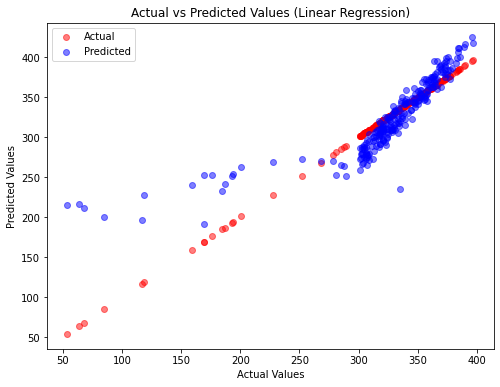

R-squared: 0.7067034410214335
Mean Squared Error: 875.4493426733766
Root Mean Squared Error: 29.587993218083863
Mean Absolute Error: 18.893845679003558


In [128]:
r2_linear,mse_linear,rmse_linear,mae_linear=lr(X_train,X_test,y_train,y_test)


### LR: balanced data

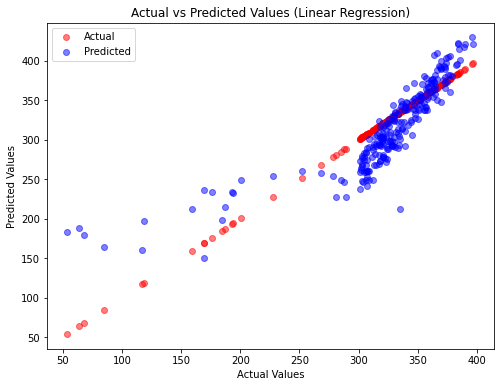

R-squared: 0.6530144045733308
Mean Squared Error: 1035.7036321575335
Root Mean Squared Error: 32.18234969913685
Mean Absolute Error: 24.510230357501683


In [129]:
r2_linear,mse_linear,rmse_linear,mae_linear=lr(X_resampled,X_test,y_resampled,y_test)


## 2. Support Vector Regression

### SVM: imbalanced data

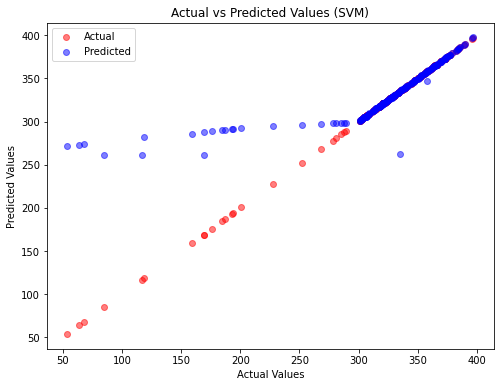

R-squared: 0.5553479856816801
Mean Squared Error: 1327.2242777379906
Root Mean Squared Error: 36.431089439350984
Mean Absolute Error: 9.855908819048505


In [130]:
r2_svr,mse_svr,rmse_svr,mae_svr=svm(X_train,X_test,y_train,y_test)

### SVM: balanced data


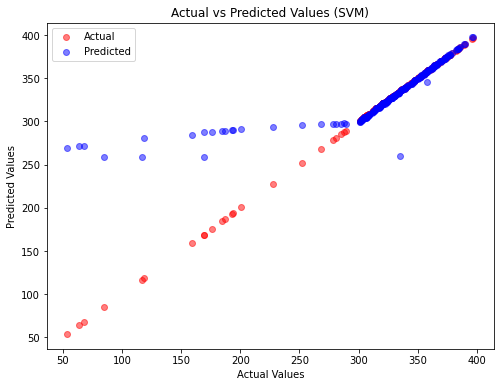

R-squared: 0.5643283342413355
Mean Squared Error: 1300.4191891583368
Root Mean Squared Error: 36.06132539381126
Mean Absolute Error: 9.964393066240515


In [131]:
r2_svr,mse_svr,rmse_svr,mae_svr=svm(X_resampled,X_test,y_resampled,y_test)

#### The balanced data generally performs slightly better than the imbalanced in terms of R-squared, MSE, and RMSE. 

## 3. Random Forest

### Random Forest: imbalanced data

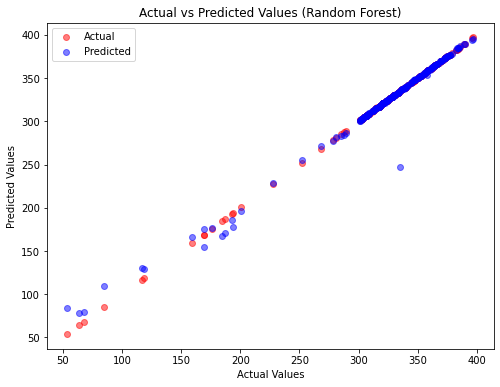

R-squared: 0.9848366214637793
Mean Squared Error: 45.26057113821138
Root Mean Squared Error: 6.727597724166583
Mean Absolute Error: 1.4124796747967459


In [132]:
r2_rf,mse_rf,rmse_rf,mae_rf=rf(X_train,X_test,y_train,y_test)

### Random Forest: balanced data


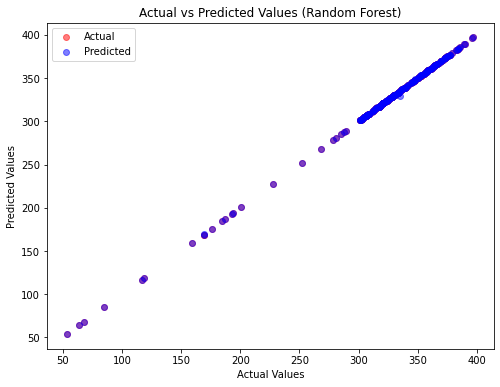

R-squared: 0.9999548639568628
Mean Squared Error: 0.13472479674796728
Root Mean Squared Error: 0.3670487661714275
Mean Absolute Error: 0.05109756097560442


In [133]:
r2_rf,mse_rf,rmse_rf,mae_rf=rf(X_resampled,X_test,y_resampled,y_test)

## 4. XG Boost

### XGB: imbalanced data

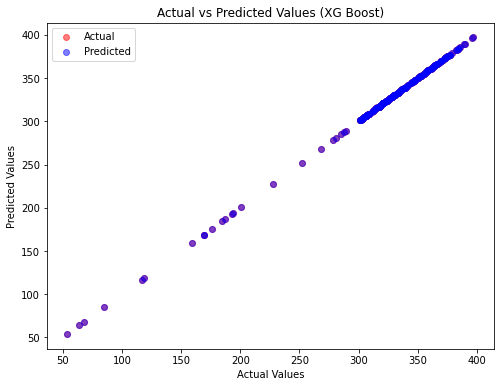

R-squared: 0.9999999995481278
Mean Squared Error: 1.3487756146284622e-06
Root Mean Squared Error: 0.0011613679927690715
Mean Absolute Error: 0.0008110108414316565


In [134]:
y_test_AV,y_pred_AV,r2_xgb,mse_xgb,rmse_xgb,mae_xgb=xgb(X_train,X_test,y_train,y_test)

### XGB: balanced data


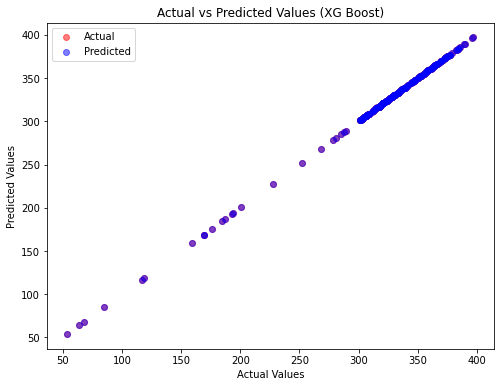

R-squared: 0.9999999988323826
Mean Squared Error: 3.485175238153708e-06
Root Mean Squared Error: 0.001866862404719134
Mean Absolute Error: 0.0009957445346243012


In [135]:
y_test_AV,y_pred_AV,r2_xgb,mse_xgb,rmse_xgb,mae_xgb=xgb(X_resampled,X_test,y_resampled,y_test)

In [136]:
y_test_AV

0      278
1      302
2      301
3      305
4      303
      ... 
241    370
242    355
243    370
244    366
245    335
Name: AQI, Length: 246, dtype: int64

### Visualise Evaluation

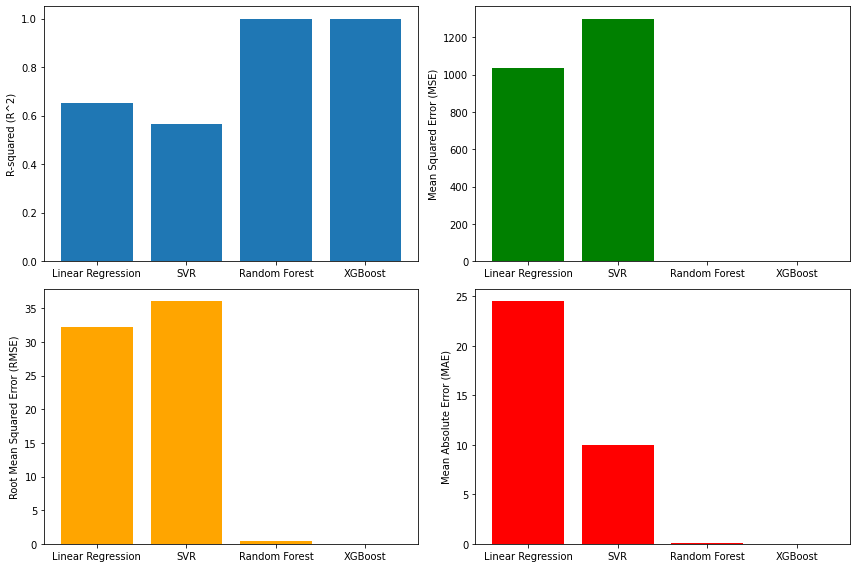

In [138]:
methods = ['Linear Regression', 'SVR', 'Random Forest', 'XGBoost']
r2_scores = [r2_linear, r2_svr, r2_rf, r2_xgb]
mse_values = [mse_linear, mse_svr, mse_rf, mse_xgb]
rmse_values = [rmse_linear, rmse_svr, rmse_rf, rmse_xgb]
mae_values = [mae_linear, mae_svr, mae_rf, mae_xgb]


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
#Plot R-squared values
axs[0, 0].bar(methods, r2_scores)
axs[0, 0].set_ylabel('R-squared (R^2)')

#Plot MSE values
axs[0, 1].bar(methods, mse_values, color='green')
axs[0, 1].set_ylabel('Mean Squared Error (MSE)')

#Plot RMSE values
axs[1, 0].bar(methods, rmse_values, color='orange')
axs[1, 0].set_ylabel('Root Mean Squared Error (RMSE)')

#Plot MAE values
axs[1, 1].bar(methods, mae_values, color='red')
axs[1, 1].set_ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()

##### XGBoost emerges as the top performer with the smallest RMSE and the highest R^2 value, making it the best model for this dataset.

##### Next in line is Random Forest (RF), showcasing the second lowest RMSE and the second highest R^2 value, solidifying its status as a strong model for this dataset.

##### Support Vector Regression (SVR) displays a lower RMSE and R^2 value compared to RF and XGBoost, indicating its competency for this dataset, albeit slightly less than the other models.

##### On the contrary, Linear Regression demonstrates the highest RMSE and the lowest R^2 value among the models, highlighting its comparatively poor fit for this dataset in comparison to the others.

# Prediciton for Punjabi Bagh

In [139]:
df,X_train,X_test,y_train,y_test,X_resampled, y_resampled= data_prep(df_PB)

Very Poor       178
Poor             32
Moderate         23
Satisfactory      3
Severe            1
Good              1
Name: AQI_category, dtype: int64

After SMOTE:
 Very Poor       567
Poor            225
Moderate        171
Satisfactory     27
Severe            9
Good              9
Name: AQI_category, dtype: int64


## 1. Linear Regression
### LR: Imbalanced data

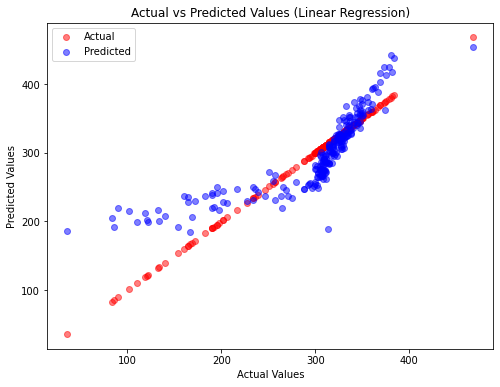

R-squared: 0.6929669697993432
Mean Squared Error: 1267.9447985254574
Root Mean Squared Error: 35.60821251516927
Mean Absolute Error: 26.01673998300234


In [142]:
r2_linear,mse_linear,rmse_linear,mae_linear=lr(X_train,X_test,y_train,y_test)

### LR: balanced data

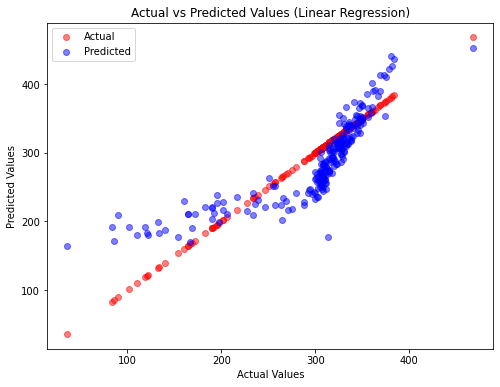

R-squared: 0.6560255220761873
Mean Squared Error: 1420.5007514141882
Root Mean Squared Error: 37.68953105856039
Mean Absolute Error: 30.223858411170486


In [143]:
r2_linear,mse_linear,rmse_linear,mae_linear=lr(X_resampled,X_test,y_resampled,y_test)

## 2. Support Vector Regression

### SVM: imbalanced data

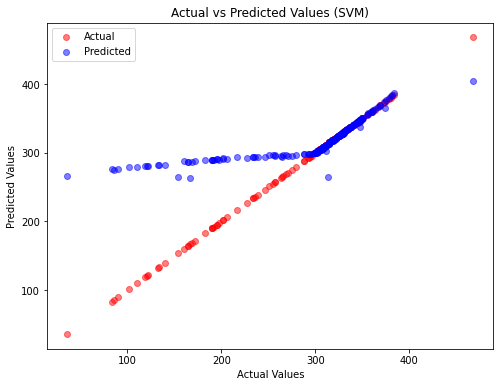

R-squared: 0.3859378575640541
Mean Squared Error: 2535.8734171506435
Root Mean Squared Error: 50.35745642058029
Mean Absolute Error: 21.000418504088334


(0.3859378575640541, 2535.8734171506435, 50.35745642058029, 21.000418504088334)

In [144]:
svm(X_train,X_test,y_train,y_test)

### SVM: balanced data


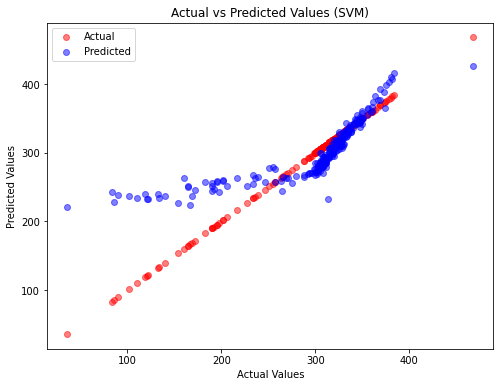

R-squared: 0.6341719280798769
Mean Squared Error: 1510.7488619142218
Root Mean Squared Error: 38.86835296117166
Mean Absolute Error: 24.544368319472525


(0.6341719280798769, 1510.7488619142218, 38.86835296117166, 24.544368319472525)

In [145]:
svm(X_resampled,X_test,y_resampled,y_test)

#### The balanced data generally performs slightly better than the imbalanced in terms of R-squared, MSE, and RMSE. 

## 3. Random Forest

### Random Forest: imbalanced data

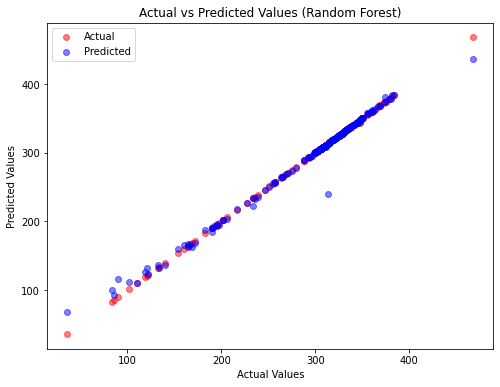

R-squared: 0.9907519133805929
Mean Squared Error: 38.19153697478992
Root Mean Squared Error: 6.179930175559423
Mean Absolute Error: 1.5159663865546185


In [146]:
r2_rf,mse_rf,rmse_rf,mae_rf=rf(X_train,X_test,y_train,y_test)

### Random Forest: balanced data


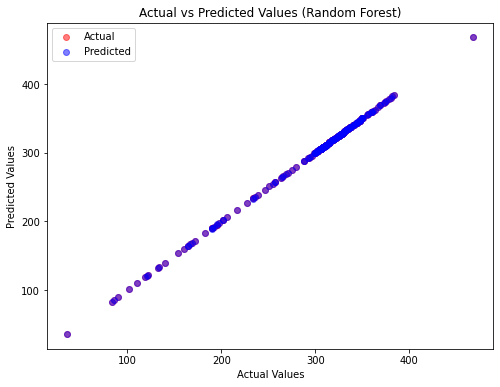

R-squared: 0.9999905075104146
Mean Squared Error: 0.03920084033613402
Root Mean Squared Error: 0.19799202089007026
Mean Absolute Error: 0.05924369747898775


In [147]:
r2_rf,mse_rf,rmse_rf,mae_rf=rf(X_resampled,X_test,y_resampled,y_test)

## 4. XG Boost

### XGB: imbalanced data

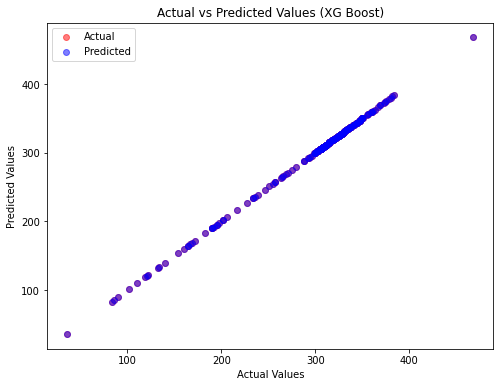

R-squared: 0.999999995990218
Mean Squared Error: 1.655907239060567e-05
Root Mean Squared Error: 0.004069284014492681
Mean Absolute Error: 0.0028256328166032037


In [148]:
y_test_PB,y_pred_PB,r2_xgb,mse_xgb,rmse_xgb,mae_xgb=xgb(X_train,X_test,y_train,y_test)

### XGB: balanced data


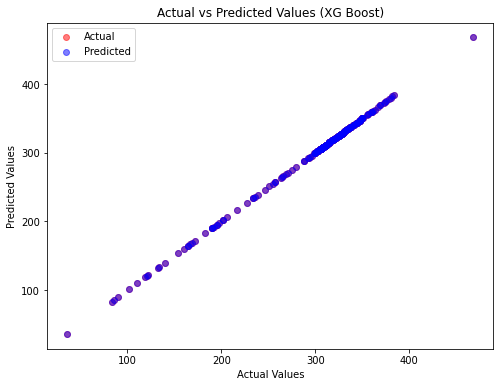

R-squared: 0.9999999971605438
Mean Squared Error: 1.172601430483178e-05
Root Mean Squared Error: 0.0034243268396623268
Mean Absolute Error: 0.0019060503534910058


In [149]:
y_test_PB,y_pred_PB,r2_xgb,mse_xgb,rmse_xgb,mae_xgb=xgb(X_resampled,X_test,y_resampled,y_test)

### Visualise Evaluation

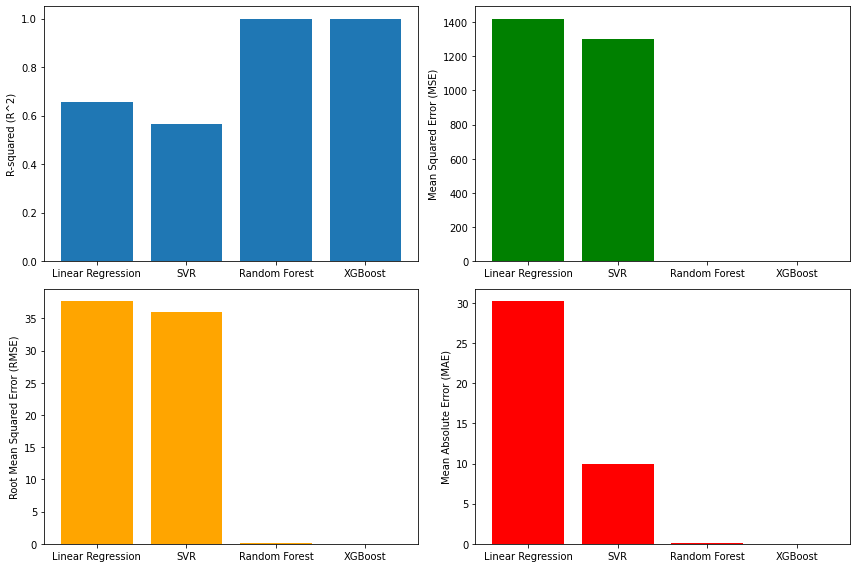

In [57]:
methods = ['Linear Regression', 'SVR', 'Random Forest', 'XGBoost']
r2_scores = [r2_linear, r2_svr, r2_rf, r2_xgb]
mse_values = [mse_linear, mse_svr, mse_rf, mse_xgb]
rmse_values = [rmse_linear, rmse_svr, rmse_rf, rmse_xgb]
mae_values = [mae_linear, mae_svr, mae_rf, mae_xgb]


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
#Plot R-squared values
axs[0, 0].bar(methods, r2_scores)
axs[0, 0].set_ylabel('R-squared (R^2)')

#Plot MSE values
axs[0, 1].bar(methods, mse_values, color='green')
axs[0, 1].set_ylabel('Mean Squared Error (MSE)')

#Plot RMSE values
axs[1, 0].bar(methods, rmse_values, color='orange')
axs[1, 0].set_ylabel('Root Mean Squared Error (RMSE)')

#Plot MAE values
axs[1, 1].bar(methods, mae_values, color='red')
axs[1, 1].set_ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()

##### XGBoost stands out with the smallest RMSE and the highest R^2 value, making it the top-performing model for this dataset.

##### Next in line is Random Forest (RF) with the second smallest RMSE and the second highest R^2 value, proving its competence on this dataset.

##### Support Vector Regression (SVR) showcases a lower RMSE and R^2 value compared to RF and XGB, signifying its suitability for the dataset but not reaching the level of the other models.

##### However, Linear Regression trails behind with the highest RMSE and the lowest R^2 value among the tested models, indicating its lesser fit for this dataset compared to the other models.

# Prediciton for Mundka

In [153]:
df,X_train,X_test,y_train,y_test,X_resampled, y_resampled= data_prep(df_MK)

Very Poor       203
Moderate         17
Poor             12
Good              3
Severe            2
Satisfactory      1
Name: AQI_category, dtype: int64

After SMOTE:
 Very Poor       544
Moderate        112
Poor             96
Severe           16
Good             16
Satisfactory      8
Name: AQI_category, dtype: int64


## 1. Linear Regression
### LR: Imbalanced data

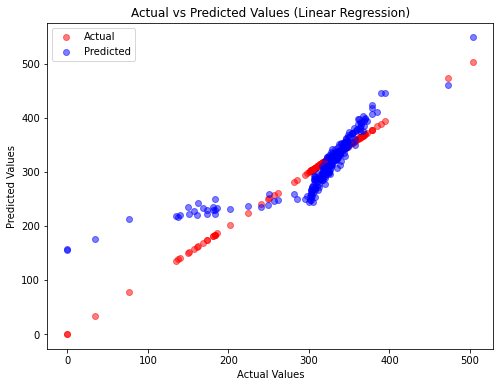

R-squared: 0.7127602228285628
Mean Squared Error: 1161.2753128090612
Root Mean Squared Error: 34.07748982552942
Mean Absolute Error: 24.212931233916432


In [155]:
r2_linear,mse_linear,rmse_linear,mae_linear=lr(X_train,X_test,y_train,y_test)

### LR: balanced data

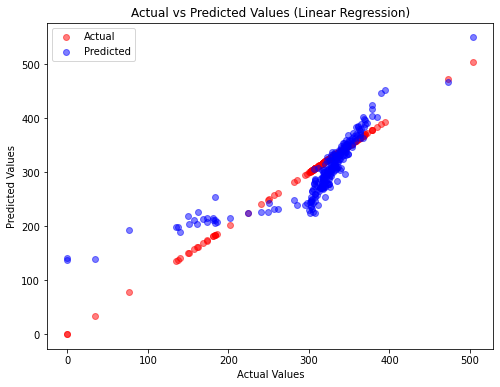

R-squared: 0.6691876918872901
Mean Squared Error: 1337.4337299927256
Root Mean Squared Error: 36.57094105970922
Mean Absolute Error: 28.267126034578357


In [156]:
r2_linear,mse_linear,rmse_linear,mae_linear=lr(X_resampled,X_test,y_resampled,y_test)

## 2. Support Vector Regression

### SVM: imbalanced data

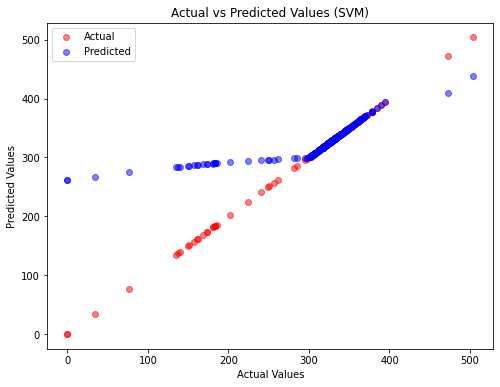

R-squared: 0.45757790728869874
Mean Squared Error: 2192.946226287835
Root Mean Squared Error: 46.82890374851663
Mean Absolute Error: 15.324020545703034


(0.45757790728869874, 2192.946226287835, 46.82890374851663, 15.324020545703034)

In [157]:
svm(X_train,X_test,y_train,y_test)

### SVM: balanced data


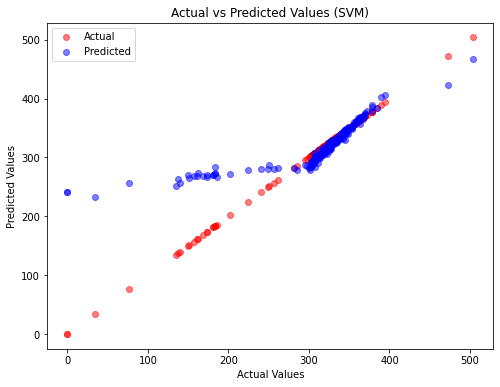

R-squared: 0.5813776398105663
Mean Squared Error: 1692.4390384403655
Root Mean Squared Error: 41.13926395112539
Mean Absolute Error: 17.93840679958448


(0.5813776398105663, 1692.4390384403655, 41.13926395112539, 17.93840679958448)

In [158]:
svm(X_resampled,X_test,y_resampled,y_test)

#### The balanced data generally performs slightly better than the imbalanced in terms of R-squared, MSE, and RMSE. 

## 3. Random Forest

### Random Forest: imbalanced data

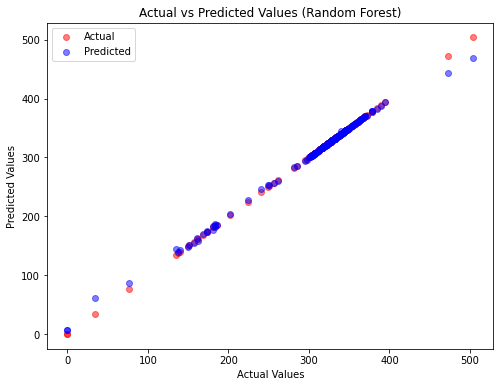

R-squared: 0.9966049627682645
Mean Squared Error: 13.725720588235292
Root Mean Squared Error: 3.7048239618415466
Mean Absolute Error: 0.9239075630252082


In [159]:
r2_rf,mse_rf,rmse_rf,mae_rf=rf(X_train,X_test,y_train,y_test)

### Random Forest: balanced data


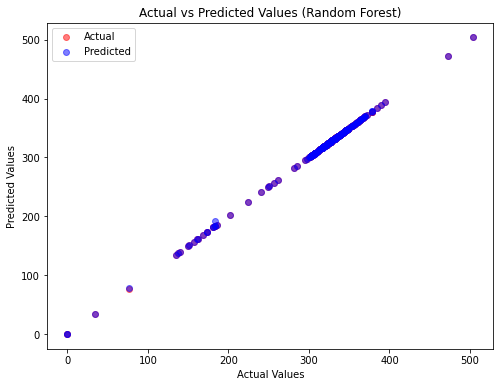

R-squared: 0.9999156124656949
Mean Squared Error: 0.3411684873949583
Root Mean Squared Error: 0.5840962997613992
Mean Absolute Error: 0.09163865546217989


In [160]:
r2_rf,mse_rf,rmse_rf,mae_rf=rf(X_resampled,X_test,y_resampled,y_test)

## 4. XG Boost

### XGB: imbalanced data

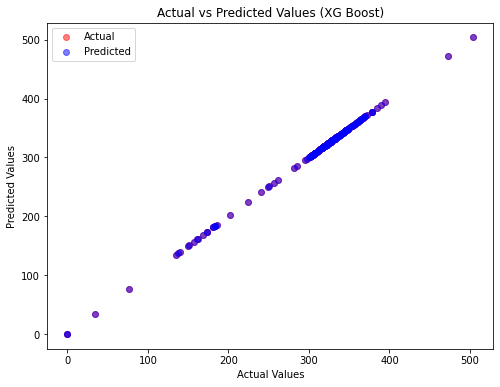

R-squared: 0.9999999990035807
Mean Squared Error: 4.028401536207367e-06
Root Mean Squared Error: 0.0020070878247369665
Mean Absolute Error: 0.0014094511387447099


In [161]:
y_test_MK,y_pred_MK,r2_xgb,mse_xgb,rmse_xgb,mae_xgb=xgb(X_train,X_test,y_train,y_test)

### XGB: balanced data


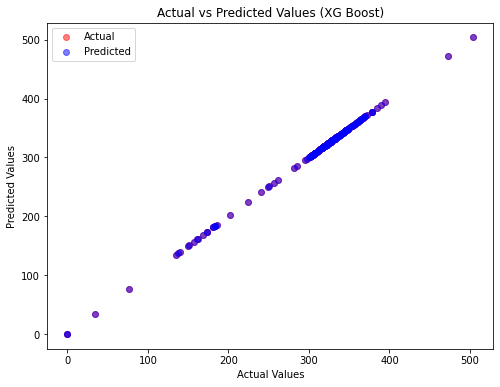

R-squared: 0.9999999971148661
Mean Squared Error: 1.1664243996688638e-05
Root Mean Squared Error: 0.00341529559433567
Mean Absolute Error: 0.0019941915191896845


In [162]:
y_test_MK,y_pred_MK,r2_xgb,mse_xgb,rmse_xgb,mae_xgb=xgb(X_resampled,X_test,y_resampled,y_test)

### Visualise Evaluation

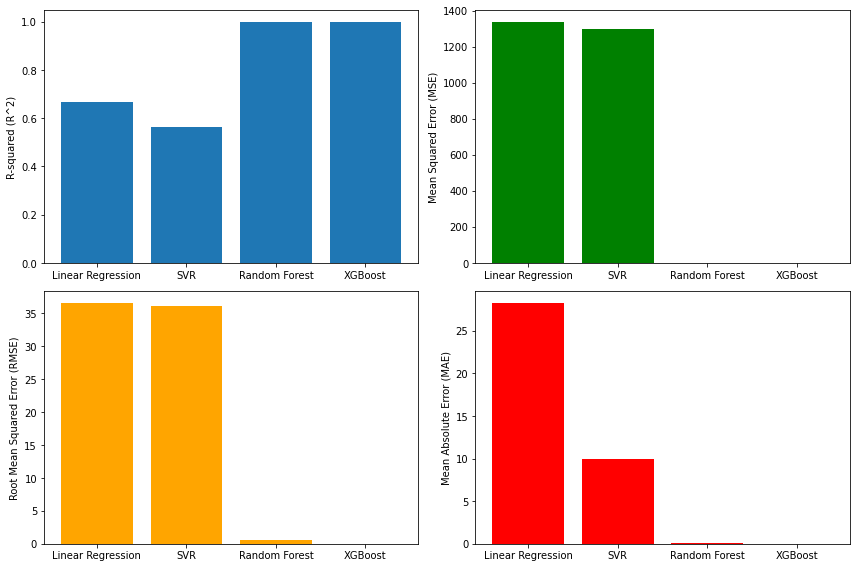

In [67]:
methods = ['Linear Regression', 'SVR', 'Random Forest', 'XGBoost']
r2_scores = [r2_linear, r2_svr, r2_rf, r2_xgb]
mse_values = [mse_linear, mse_svr, mse_rf, mse_xgb]
rmse_values = [rmse_linear, rmse_svr, rmse_rf, rmse_xgb]
mae_values = [mae_linear, mae_svr, mae_rf, mae_xgb]


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
#Plot R-squared values
axs[0, 0].bar(methods, r2_scores)
axs[0, 0].set_ylabel('R-squared (R^2)')

#Plot MSE values
axs[0, 1].bar(methods, mse_values, color='green')
axs[0, 1].set_ylabel('Mean Squared Error (MSE)')

#Plot RMSE values
axs[1, 0].bar(methods, rmse_values, color='orange')
axs[1, 0].set_ylabel('Root Mean Squared Error (RMSE)')

#Plot MAE values
axs[1, 1].bar(methods, mae_values, color='red')
axs[1, 1].set_ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()

##### XGBoost has the lowest RMSE and the highest R^2 value, indicating it is the best model for this dataset.

##### Random Forest (RF) has the second lowest RMSE and the second highest R^2 value, indicating it is also a good model for this dataset.

##### Support Vector Regression (SVR) has a lower RMSE and R^2 value than RF and XGB, suggesting that it is a good fit for this dataset but not as good as the other two models.

#####  Linear Regression has the highest RMSE and the lowest R^2 value among the models tested, indicating that it is not as good a fit for this dataset as the other models.

# AQI for all 3 cities in the following days

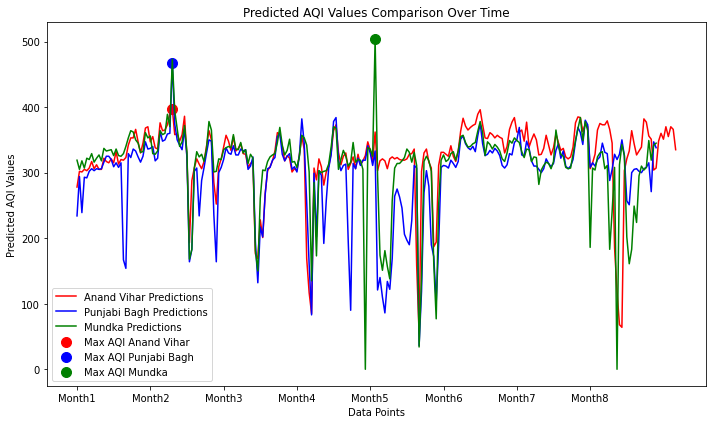

Maximun AQI:
Anand Vihar: 397.0
Punjabi Bhag: 468.0
Mundka: 504.0


In [191]:
#calculate the number of months (based on 30 data points per month)
total_data_points = len(y_pred_AV)
num_months = total_data_points // 30
num_months = math.ceil(num_months)
#create x-axis ticks for each month
month_ticks = ['Month{}'.format(i + 1) for i in range(num_months)]

#maximum predicted AQI values for each city
max_index_city1 = np.argmax(y_pred_AV)
max_index_city2 = np.argmax(y_pred_PB)
max_index_city3 = np.argmax(y_pred_MK)

#plotting predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_pred_AV, color='red', label='Anand Vihar Predictions')
plt.plot(y_pred_PB, color='blue', label='Punjabi Bagh Predictions')
plt.plot(y_pred_MK, color='green', label='Mundka Predictions')

#marking the highest predicted AQI values for each city
plt.scatter(max_index_city1, y_pred_AV[max_index_city1], color='red', s=100, label='Max AQI Anand Vihar')
plt.scatter(max_index_city2, y_pred_PB[max_index_city2], color='blue', s=100, label='Max AQI Punjabi Bagh')
plt.scatter(max_index_city3, y_pred_MK[max_index_city3], color='green', s=100, label='Max AQI Mundka')
plt.xticks(np.arange(0, 240, 30), month_ticks)

plt.xlabel('Data Points')
plt.ylabel('Predicted AQI Values')
plt.title('Predicted AQI Values Comparison Over Time')
plt.legend()
plt.tight_layout()
plt.show()

print("Maximun AQI:")
print("Anand Vihar:",y_pred_AV[max_index_city1].round())
print("Punjabi Bhag:",y_pred_PB[max_index_city2].round())
print("Mundka:",y_pred_MK[max_index_city3].round() )

## Results and Findings:

##### Overall, the predicted AQI values seem to be decreasing over time.This suggests that the air quality in these areas is generally improving over the specified period.
##### Anand Vihar, Punjabi Bagh, and Mundka show varying trends over time.
##### Anand Vihar's AQI values consistently decrease, indicating better air quality compared to Punjabi Bagh and Mundka.
##### Punjabi Bagh and Mundka exhibit a fluctuating pattern, indicating less stable air quality compared to Anand Vihar.
##### Maximun AQI:
##### Anand Vihar: 397    Very Poor
##### Punjabi Bhag: 468  Very Poor
##### Mundka: 504           Severe




## Conclusion:

##### This project addressed the challenge of imbalanced datasets through the application of SMOTE, enhancing the model's ability to learn from underrepresented data. By implementing XGBoost, Random Forest, Support Vector Regression, and Linear Regression models, we identified XGBoost as the optimal choice due to its lowest RMSE and highest R^2 value. This model not only showcased superior performance but also highlighted the importance of proper handling of imbalanced data. Through SMOTE, we effectively balanced the dataset, enabling more accurate predictions and emphasizing the significance of addressing class imbalance in machine learning applications
##### The variability in AQI values between the areas indicates a need for more precise air quality monitoring and data-driven policies to maintain air quality standards.

